<a href="https://colab.research.google.com/github/ms-shyamkumar/demand-forecasting/blob/main/gluonts_deepAR_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade mxnet~=1.7 gluonts

Data import and preprocessing

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
file = 'posoco_electricty_demand_met.csv'
df = pd.read_csv(file, header=0, index_col=0)
north_demand = df[df['Region']=='North'][['Demand_MW']]
north_demand.index = pd.to_datetime(north_demand.index, format='%m/%d/%y')
north_demand.sort_index(inplace=True)
north_demand.head()

,Demand_MW
Date,
2017-01-01,40444
2017-01-02,42018
2017-01-03,41533
2017-01-04,42548
2017-01-05,43461


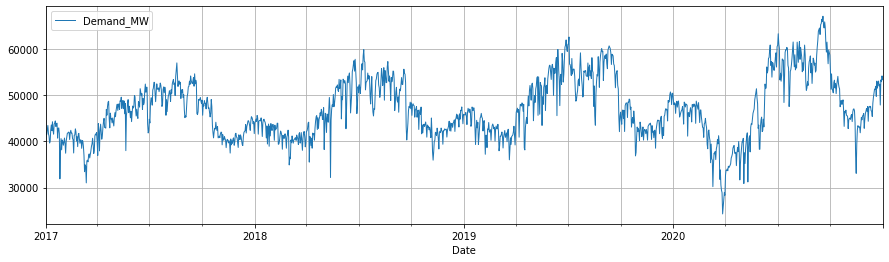

In [3]:
north_demand.plot(linewidth=1, figsize=(15,4))
plt.grid(which='both')
plt.show()

Train & Test Dataset creation

In [4]:
from gluonts.dataset.common import ListDataset
training_data = ListDataset(
    [{"start": north_demand.index[0], "target": north_demand.Demand_MW[:-90]}],
    freq = "D"
)
test_data = ListDataset(
    [{"start": north_demand.index[0], "target": north_demand.Demand_MW}],
    freq = "D"
)

Model training

In [12]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

estimator = DeepAREstimator(freq="D", prediction_length=550, num_cells=60, 
                            trainer=Trainer(epochs=10,learning_rate=0.01),)
predictor = estimator.train(training_data=training_data)

100%|██████████| 50/50 [01:58<00:00,  2.37s/it, epoch=10/10, avg_epoch_loss=8.99]


Forecasting

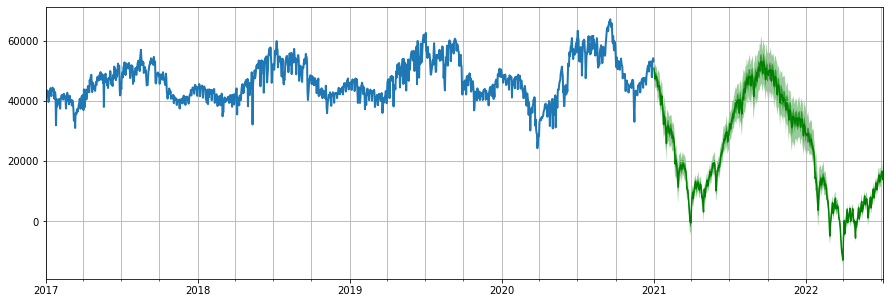

In [6]:
from gluonts.dataset.util import to_pandas

for test_entry, forecast in zip(test_data, predictor.predict(test_data)):
    to_pandas(test_entry).plot(linewidth=2, figsize=(15,5))
    forecast.plot(color='g')
plt.grid(which='both')

Model Evaluation

In [10]:
from gluonts.evaluation.backtest import make_evaluation_predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=550,  # number of sample paths we want for evaluation
)

In [11]:
from gluonts.evaluation import Evaluator
import json
forecasts = list(forecast_it)
tss = list(ts_it)
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))
print(' RMSE', json.dumps(agg_metrics['RMSE']))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 20.52it/s]

 RMSE 15573.039924176654
